В данном проекте исследуется поведение покупателей интернет-магазина "В один клик" с целью удерживать активность постоянных клиентов. Для предсказания снижения покупательской активности в будущем мы построим ML-модель. В основе будут лежать 4 типа ключевых признаков:

- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

На основе модели будут выделены ключевые факторы, влияющие на вероятность снижения покупательской активности, а также сегменты пользователей, имеющих наибольшую вероятность снижения активности.

In [1]:
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
import phik

from itertools import product
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")

In [2]:
# константы модели
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
def remove_dupes(df):
    """Считает количество явных дубликатов в датасете, выводит на экран их количество и удаляет дубликаты"""
    duplicate_rows = df.duplicated()
    print(len(df[duplicate_rows]))
    df.drop_duplicates(inplace=True)
    return(df)

In [4]:
def find_dupes(df):
    """Вспомогательная функция для поиска неявных дубликатов"""
    cat_columns = df.select_dtypes(exclude=['number']).columns
    for column in cat_columns:
        print(df[column].value_counts(ascending=False))

In [5]:
def analyze_num_columns(df, column):
    """Функция для исследовательского анализа количественных признаков"""
    df.hist(column=column, color='mediumseagreen', bins=20)
    plt.show()
    
    print('\n')
    df.boxplot(column=column)
    plt.show()

## Шаг 1. Загрузка данных

In [6]:
# импорт датасета market_file
path_local_m = 'datasets/market_file.csv'
path_hub_m = '/datasets/market_file.csv'

if os.path.exists(path_local_m):
    market_file = pd.read_csv(path_local_m)
elif os.path.exists(path_hub_m):
    market_file = pd.read_csv(path_hub_m)
else:
    print('Ошибка в пути к файлу')

market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
# импорт датасета market_money
path_local_m = 'datasets/market_money.csv'
path_hub_m = '/datasets/market_money.csv'

if os.path.exists(path_local_m):
    market_money = pd.read_csv(path_local_m)
elif os.path.exists(path_hub_m):
    market_money = pd.read_csv(path_hub_m)
else:
    print('Ошибка в пути к файлу')

market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
# импорт датасета market_time
path_local_m = 'datasets/market_time.csv'
path_hub_m = '/datasets/market_time.csv'

if os.path.exists(path_local_m):
    market_time = pd.read_csv(path_local_m)
elif os.path.exists(path_hub_m):
    market_time = pd.read_csv(path_hub_m)
else:
    print('Ошибка в пути к файлу')

market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
# импорт датасета money
path_local_m = 'datasets/money.csv'
path_hub_m = '/datasets/money.csv'

if os.path.exists(path_local_m):
    money = pd.read_csv(path_local_m)
elif os.path.exists(path_hub_m):
    money = pd.read_csv(path_hub_m)
else:
    print('Ошибка в пути к файлу')

money.head()

,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


Датасет `money` не считался корректно из-за неверного разделителя, поэтому исправим это ниже.

In [10]:
# импорт датасета money
path_local_m = 'datasets/money.csv'
path_hub_m = '/datasets/money.csv'

if os.path.exists(path_local_m):
    money = pd.read_csv(path_local_m, sep=';')
elif os.path.exists(path_hub_m):
    money = pd.read_csv(path_hub_m, sep=';')
else:
    print('Ошибка в пути к файлу')

money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Мы загрузили 4 датафрейма, теперь изучим их содержимое.

In [11]:
def dataset_overview(dataset):
    print(dataset.shape)
    dataset.info()

In [12]:
datasets = [market_file, market_money, market_time, money]

for dataset in datasets:
    dataset_overview(dataset)

(1300, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса     

Данные соответствуют описанию.

На данном шаге были успешно загружены 4 датасета, а также первично изучены датафреймы на соответствие описанию.

## Шаг 2. Предобработка данных

Сначала заменим типы данных на корректные: такая предобработка необходима только для числового столбцы `Прибыль` в датафрейме `money`:

In [13]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Теперь проверим, есть ли явные дубликаты в данных:

In [14]:
help(remove_dupes)

Help on function remove_dupes in module __main__:

remove_dupes(df)
    Считает количество явных дубликатов в датасете, выводит на экран их количество и удаляет дубликаты



In [15]:
for df in datasets:
    print('Изначальный размер датасета', df.shape)
    df = remove_dupes(df)
    print('Итоговый размер датасета', df.shape)

Изначальный размер датасета (1300, 13)
0
Итоговый размер датасета (1300, 13)
Изначальный размер датасета (3900, 3)
0
Итоговый размер датасета (3900, 3)
Изначальный размер датасета (2600, 3)
0
Итоговый размер датасета (2600, 3)
Изначальный размер датасета (1300, 2)
0
Итоговый размер датасета (1300, 2)


Явных дубликатов нет, поэтому теперь проверим возможные неявные дубликаты в текстовых столбцах:

In [16]:
for df in datasets:
    find_dupes(df)
    print('\n')

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64
Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64
Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64
Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64


Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64






Заметим, что в данных есть две опечатки:
- неявный дубликат в столбце `Тип сервиса` датасета `market_file`: стандарт и стандартт
- опечатка в столбце `Период` `market_time`: предыдущий_месяц вместо предыдцщий_месяц

In [17]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')
market_file['Тип сервиса'].value_counts(ascending=False)

Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [18]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['Период'].value_counts(ascending=False)

Период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

Пропусков в данных нет

На этапе предобработки данных были выявлены и заменены неявные дубликаты в данных, а также данные подготовлены для дальнейшего анализа.

## Шаг 3. Исследовательский анализ данных

In [19]:
def analyze_cat_columns(df, column, title):
    df.groupby(column)['id'].count().plot(kind='bar', 
                                  color='mediumseagreen', 
                                  edgecolor='gray',
                                  title=title)
    plt.show()
    
    print(df[column].value_counts(normalize=True))
    
    print(df[column].value_counts())

In [20]:
cat_columns = market_file.select_dtypes(exclude=['number']).columns

print(cat_columns)

Index(['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Популярная_категория'],
      dtype='object')


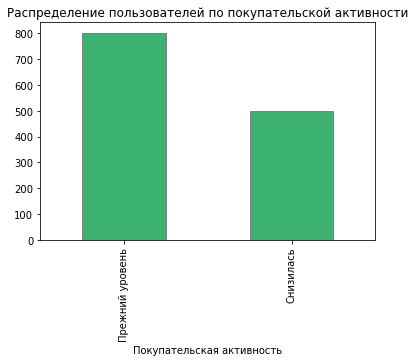

Покупательская активность
Прежний уровень    0.616923
Снизилась          0.383077
Name: proportion, dtype: float64
Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64


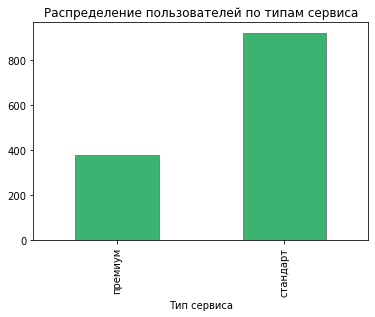

Тип сервиса
стандарт    0.710769
премиум     0.289231
Name: proportion, dtype: float64
Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64


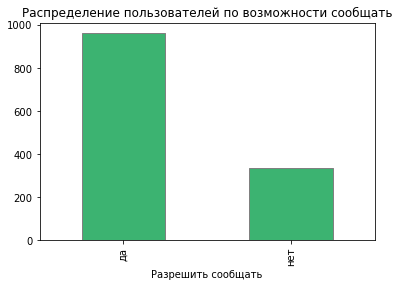

Разрешить сообщать
да     0.74
нет    0.26
Name: proportion, dtype: float64
Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64


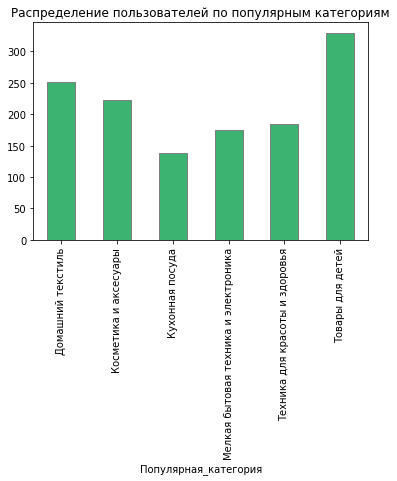

Популярная_категория
Товары для детей                        0.253846
Домашний текстиль                       0.193077
Косметика и аксесуары                   0.171538
Техника для красоты и здоровья          0.141538
Мелкая бытовая техника и электроника    0.133846
Кухонная посуда                         0.106154
Name: proportion, dtype: float64
Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


In [21]:
cat_columns = market_file.select_dtypes(exclude=['number']).columns

titles = ['Распределение пользователей по покупательской активности',
          'Распределение пользователей по типам сервиса',
          'Распределение пользователей по возможности сообщать',
          'Распределение пользователей по популярным категориям']

column_title_map = dict(zip(cat_columns, titles))

for column in cat_columns:
    title = column_title_map[column]
    analyze_cat_columns(market_file, column, title)

По результатам анализа категориальных признаков, можно сделать следующие выводы о пользователях:
- У 62% пользователей покупательская активность сохранилась на прежнем уровне, а у 38% - снизилась
- 71% пользователей пользуются стандартным сервисом, а оставшиеся 29% - премиальным
- 74% пользователей дали согласие на то, чтобы присылать дополнительные предложения о товаре
- Наиболее популярной категорией является "Товары для детей" (25%), наименее популярной - Кухонная посуда (11%)

Теперь проанализируем количественные признаки в датасете `market_file`: посмотрим на описательную статистику датасета в целом, построим гистограмму и ящик с усами.

In [22]:
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [23]:
def analyze_num_columns(df, column):
    df.hist(column=column, color='mediumseagreen', bins=20)
    plt.show()
    
    print('\n')
    df.boxplot(column=column)
    plt.show()

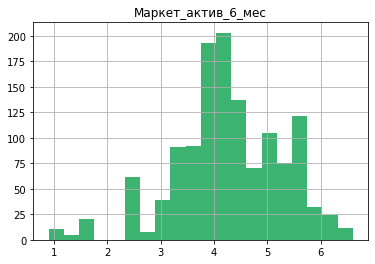

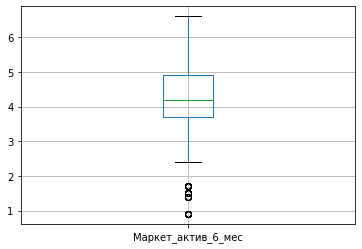

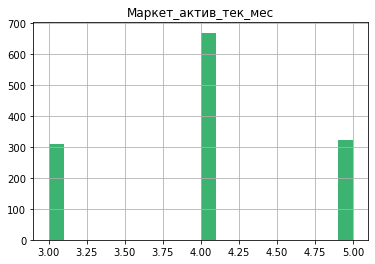

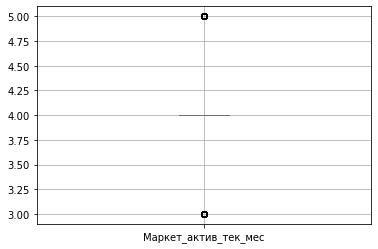

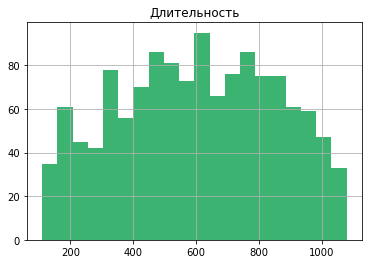

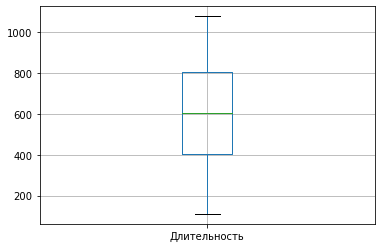

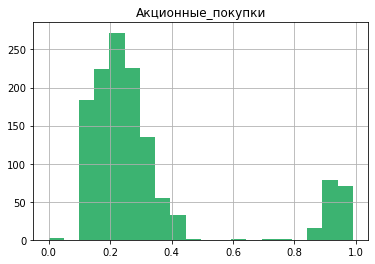

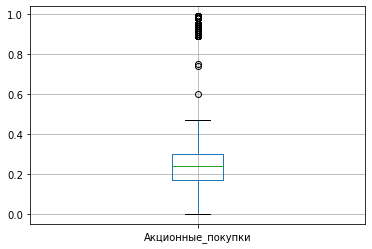

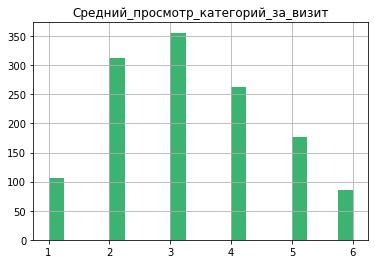

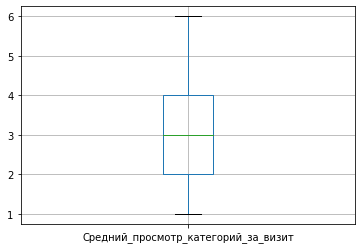

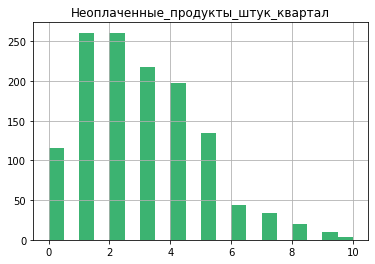

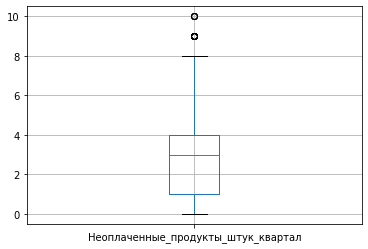

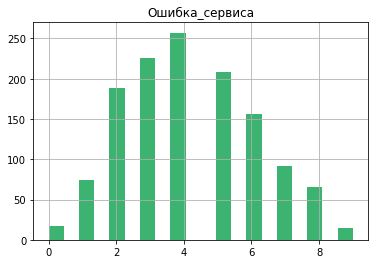

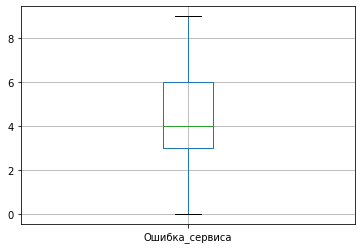

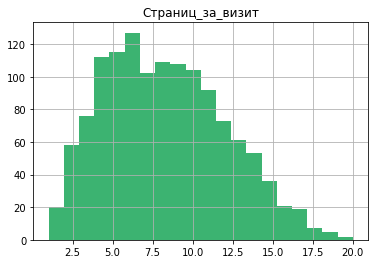

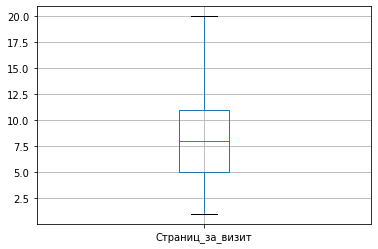

In [24]:
num_columns = market_file.select_dtypes(include=['number']).columns
num_columns = num_columns[num_columns != 'id']

for column in num_columns:
    analyze_num_columns(market_file, column)

Анализ количественных признаков показал следующее:
- В среднем пользователи имеют 4.25 маркетинговых коммуникаций в месяц за последние 6 месяцев, на гистограмме выделяется группа пользователей с низким уровнем коммуникаций, а также 4 пика для пользователей, имеющих более 2 коммуникаций в месяц
- За последний месяц пользователи имеют в среднем 4 коммуникации, распределение дискретное, то есть возможно только 3 варианта: 3, 4 или 5 коммуникаций за последний месяц
- В среднем пользователи зарегистрированы 606 дней на сайте (почти 2 года!), минимальное количество дней с момента регистрации - 110, максимальное - 1079
- Наблюдаются два типа пользователей по взаимодействию с акциями: пользователи, иногда покупающие акционные товары, и пользователи, которые в основном покупают продукты по акции. На гистограмме это видно по двум пикам
- В среднем пользователи просматривают 3.27 категорий за один визит
- В среднем за квартал пользователи не оплачивают 2.84 товаров
- Распределение ошибок сервиса близко к нормальному со средним 4.2 сбоев за посещение
- В среднем пользователи посещают 8.2 страниц за визит

Теперь рассмотрим оставшиеся три датасета.

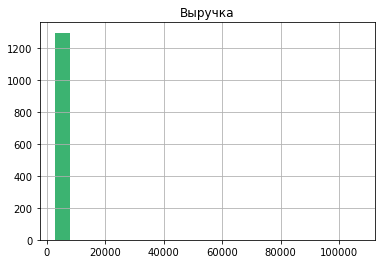

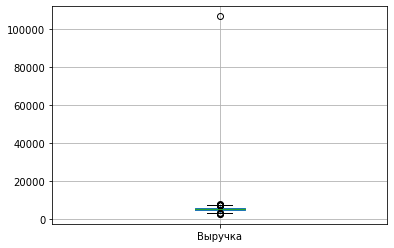

In [25]:
analyze_num_columns(market_money.query('Период == "текущий_месяц"'), "Выручка")

Заметим, что в данных есть выброс: пользователь, который потратил в текущем месяце более 100000 рублей. Такое возможно, однако, это может повлиять на качество модели, поэтому уберем из данных пользователя.

In [26]:
anomaly = market_money[market_money["Выручка"] > 100000]['id'].unique()

In [27]:
market_money = market_money[~market_money['id'].isin(anomaly)]
market_file = market_file[~market_file['id'].isin(anomaly)]
market_time = market_time[~market_time['id'].isin(anomaly)]
money = money[~money['id'].isin(anomaly)]

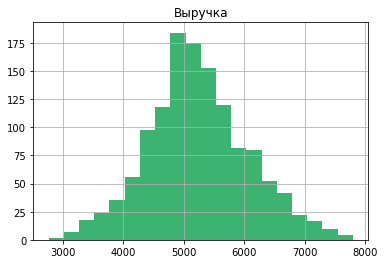

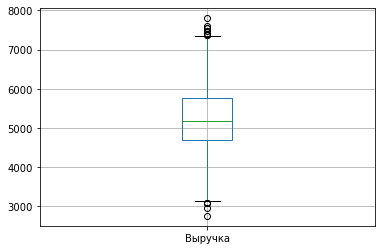

In [28]:
analyze_num_columns(market_money.query('Период == "текущий_месяц"'), "Выручка")

Заметим, что распределение выручки близко к нормальному, с пиком около 5000 рублей в месяц.

Проанализируем данные за предыдущий месяц и препредыдущий:

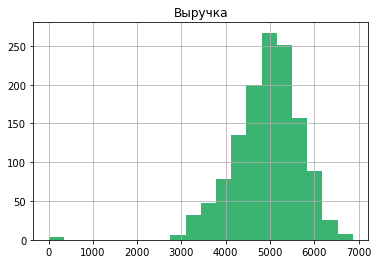

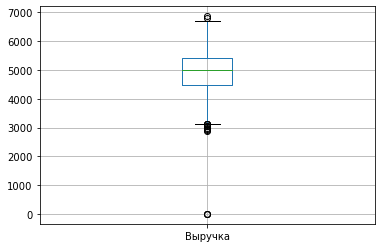

In [29]:
analyze_num_columns(market_money.query('Период == "предыдущий_месяц"'), "Выручка")

In [30]:
market_money.query('Период == "предыдущий_месяц"').describe()

,id,Выручка
count,1299.000000,1299.000000
mean,215997.975366,4936.042725
std,375.174972,739.205300
min,215348.000000,0.000000
25%,215673.500000,4496.500000
50%,215998.000000,5004.500000
75%,216322.500000,5404.250000
max,216647.000000,6869.500000


В данных есть аномалия - прибыль на сумму 0 рублей. Во всем остальном распределение прибыли близко к нормальному.

In [31]:
market_money.query('Выручка == 0')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Таких пользователей 3, скорее всего, это пользователи, которые недавно начали совершать покупки, поэтому прибыль от них равна нулю.

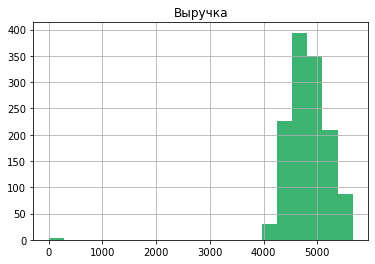

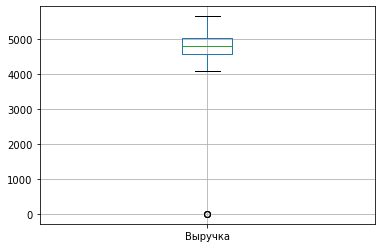

In [32]:
analyze_num_columns(market_money.query('Период == "препредыдущий_месяц"'), "Выручка")

За препредыдущий месяц гистограмма идентична, также есть пользователи, которые принесли нулевую выручку.

Теперь рассмотрим таким же образом данные о времени проведенном на сайте:

In [33]:
market_time.query('Период == "текущий_месяц"').describe()

,id,минут
count,1299.000000,1299.000000
mean,215997.975366,13.204003
std,375.174972,4.222157
min,215348.000000,4.000000
25%,215673.500000,10.000000
50%,215998.000000,13.000000
75%,216322.500000,16.000000
max,216647.000000,23.000000


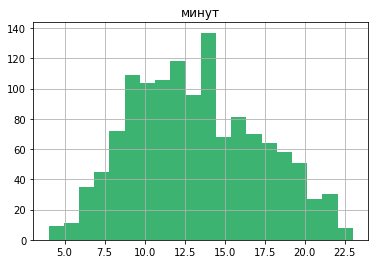

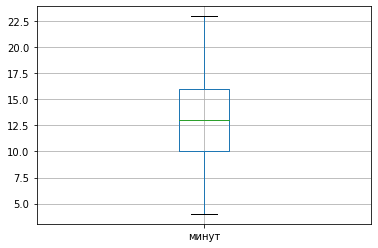

In [34]:
analyze_num_columns(market_time.query('Период == "текущий_месяц"'), "минут")

Распределение имеет форму колокола, минимальное время на сайте - 4 минуты, максимально - 23 минуты, среднее время - 13.2 минуты.

In [35]:
market_time.query('Период == "предыдущий_месяц"').describe()

,id,минут
count,1299.000000,1299.000000
mean,215997.975366,13.468822
std,375.174972,3.933332
min,215348.000000,5.000000
25%,215673.500000,11.000000
50%,215998.000000,13.000000
75%,216322.500000,17.000000
max,216647.000000,23.000000


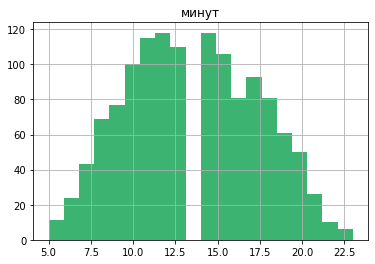

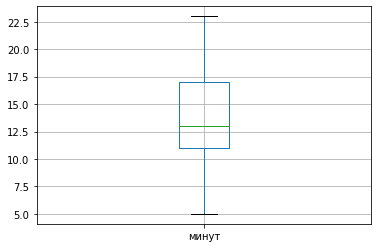

In [36]:
analyze_num_columns(market_time.query('Период == "предыдущий_месяц"'), "минут")

Распределение также имеет форму колокола. Единственная аномалия - отсутствие пользователей, которые провели на сайте от 13 до 14 минут.

Наконец, проанализируем среднемесячную прибыль за последние 3 месяца:

In [37]:
money.describe()

,id,Прибыль
count,1299.000000,1299.000000
mean,215997.975366,3.996721
std,375.174972,1.014107
min,215348.000000,0.860000
25%,215673.500000,3.300000
50%,215998.000000,4.050000
75%,216322.500000,4.670000
max,216647.000000,7.430000


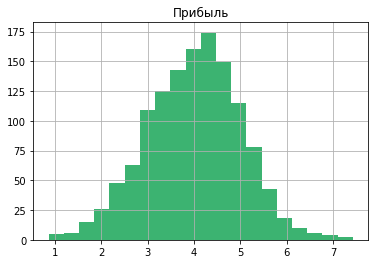

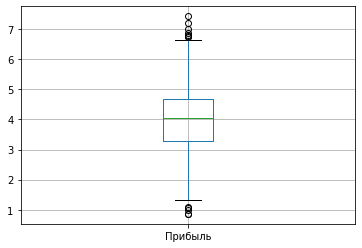

In [38]:
analyze_num_columns(money, "Прибыль")

Прибыль также имеет распределение в форме колокола, со средним значением 4.

Теперь выберем тех покупателей, у которых была покупательская активность за последние 3 месяца.

In [39]:
valid_ids = market_money.groupby('id').filter(lambda x: (x['Выручка'] > 0).all())['id'].unique()

market_money = market_money[market_money['id'].isin(valid_ids)]

market_money.shape

(3888, 3)

С помощью кода выше мы оставили только тех покупателей, которые совершали покупки в течение последних трех месяцев.

На этапе исследовательского анализа данных:
- были изучены категориальные и количественные признаки во всех датасетах
- выделены возможные аномалии в данных
- выбраны только те пользователи, которые совершали покупки в течение последних трех месяцев.

## Шаг 4. Объединение таблиц

На этом шаге мы объединим три датафрейма: `market_file`, `market_money`, `market_time`:
- сначала преобразуем датасеты `market_money` и `market_time` из "длинной" формы в "широкую"
- выделим только тех пользователей во всех датасетах, которые совершали 
- объединим все три датасета

In [40]:
market_money = market_money.pivot(index='id', columns='Период', values='Выручка')
market_money = market_money.reset_index()
market_money.columns = ['id', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка']
market_money.head()

,id,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [41]:
market_time = market_time.pivot(index='id', columns='Период', values='минут')
market_time = market_time.reset_index()
market_time.columns = ['id', 'предыдущий_месяц_минут', 'текущий_месяц_минут']
market_time.head()

,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [42]:
market_time = market_time[market_time['id'].isin(valid_ids)]
market_file = market_file[market_file['id'].isin(valid_ids)]

print(market_time.shape)
print(market_file.shape)

(1296, 3)
(1296, 13)


In [43]:
merged_data = pd.merge(market_file, market_money, on='id', how='inner')
data = pd.merge(merged_data, market_time, on='id', how='inner')
print(data.shape)
data.head()

(1296, 18)


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## Шаг 5. Корреляционный анализ

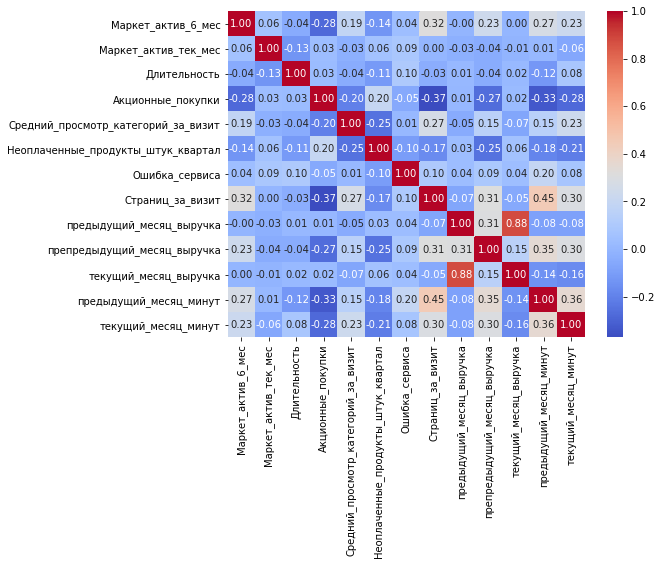

In [44]:
num_col_names = data.select_dtypes(include='number').columns.drop('id').tolist()

plt.figure(figsize=(8, 6))
sns.heatmap(data[num_col_names].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm') 

plt.show()

In [45]:
data.drop('id', axis=1).phik_matrix() 

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_минут', 'текущий_месяц_минут']


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
Покупательская активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770
Тип сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000
Разрешить сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000
Маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601
Маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
Длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481
Акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558
Популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883
Средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568
Неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383


Заметим, что между показателями либо слабая, либо умеренная связь.

По итогам корреляционного анализа заметим, что среди количественных признаков нет признаков с сильной линейной связью, а значит, мультиколлинеарность не возникнет.

## Шаг 6. Использование пайплайнов

Создадим модели для обработки данных. В рамках создания модели будем использовать пайплайны. Выделим следующие шаги:
- фиксация констант: RANDOM_STATE и размер тестовой выборки
- разделение данных на тренировочные и валидационные
- создание списков столбцов с категориальными и количественными признаками
- создание пайплайна для обработки категориальных признаков с помощью OneHotEncoder
- создание общего пайплайна для обработки данных
- создание итогового пайплайна: обработка данных и модель
- создание словаря со списком моделей и гиперпараметров
- запуск рандомизированного поиска лучшей модели
- выбор лучшей модели на основе метрике roc_auc: в данном случае эта метрика предпочтительна, т.к. не зависит от выбранных порогов вероятности

In [46]:


X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Покупательская активность','id'], axis=1),
    data['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['Покупательская активность'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()
num_columns = X_train.select_dtypes(include='number').columns.tolist()

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='error', sparse_output=False, drop='first'))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            kernel='poly'
        )],
        'models__degree': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Тип '
                                                                                'сервиса',
                                                                                'Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('num',
                                                                               MinMaxScaler(),...
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly')],
                                         'models__degree': range(2, 8),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [47]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кроссвалидационной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Марке

Лучшей моделью является модель логистической регрессии с параметрами: C=1, penalty='l1', solver='liblinear'

Для данной модели целевая метрика на кроссвалидационной выборке roc_auc составляет 0.898

In [48]:
best_model = randomized_search.best_estimator_
pred = best_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, pred)
print('Метрика ROC-AUC на тестовой выборке:\n\n', roc_auc)

Метрика ROC-AUC на тестовой выборке:

 0.9182138090037617


In [49]:
classes = best_model.named_steps['models'].classes_
print("Classes:", classes)

Classes: ['Прежний уровень' 'Снизилась']


## Шаг 7. Анализ важности признаков

In [50]:
# Assuming randomized_search is your trained RandomizedSearchCV object
best_model = randomized_search.best_estimator_

# Apply the pipeline to the test data
y_pred = best_model.predict(X_test)

# Create a SHAP explainer object
# Note: Ensure that the model used here can be interpreted by SHAP. Most tree-based models are supported directly.
explainer = shap.Explainer(best_model.named_steps['models'], best_model.named_steps['preprocessor'].transform(X_train))

# Compute SHAP values for the transformed test data
shap_values = explainer(best_model.named_steps['preprocessor'].transform(X_test))


In [51]:
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer."""
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(pipe, 'named_steps'):
            if 'ohe' in pipe.named_steps:
                ohe = pipe.named_steps['ohe']
                if isinstance(ohe, OneHotEncoder):
                    feature_names = ohe.get_feature_names_out(input_features=features)
                    output_features.extend(feature_names)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)

    return output_features

# Extract feature names from the pipeline
transformed_feature_names = get_feature_names(best_model.named_steps['preprocessor'])

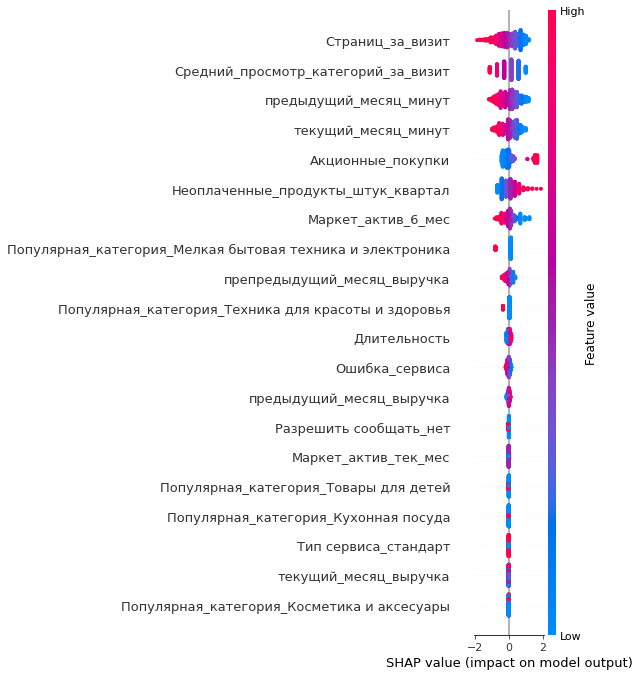

In [52]:
shap.summary_plot(shap_values, best_model.named_steps['preprocessor'].transform(X_test), feature_names=transformed_feature_names)

По графику можно видеть, что основными факторами, влияющими на снижение активности являются:
- количество страниц за визит (чем больше, тем меньше вероятность снижения активности)
- среднее количество категорий за визит (чем больше, тем меньше вероятность снижения активности)
- количество минут, проведенных на сайте за предыдущий месяц (чем больше, тем меньше вероятность снижения активности)
- количество неоплаченных продуктов (чем больше, тем больше вероятность снижения активности)
- доля акционных покупок (чем больше, тем больше вероятность снижения активности)

Меньше всего влияют на снижение активности категория товаров, маркетинговая активность и выручка в *текущем* месяце и разрешение сообщать о маркетинговых акциях

Заметим, что наиоблее значимыми признаками являются признаки, отвечающие за продуктовое поведение клиента и поведение на сайте, следовательно, необходимо сосредоточиться на факторах, отвечающих за эти два типа поведений.

## Шаг 8. Сегментация покупателей

In [53]:
data = pd.merge(data, money, on='id', how='left')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   object 
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

In [54]:
data['Покупательская_активность_pred'] = best_model.predict_proba(data.drop(['Покупательская активность','id', 'Прибыль'], axis=1))[:,1]

In [55]:
data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,Прибыль,Покупательская_активность_pred
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16,0.868285
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13,0.328846
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87,0.771397
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21,0.947552
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95,0.604037


In [56]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1296.0,215999.464506,374.327860,215349.000000,215675.750000,215999.500000,216323.250000,216647.00000
Маркет_актив_6_мес,1296.0,4.256404,1.013525,0.900000,3.700000,4.200000,4.900000,6.60000
Маркет_актив_тек_мес,1296.0,4.009259,0.696316,3.000000,4.000000,4.000000,4.000000,5.00000
Длительность,1296.0,602.967593,249.195823,121.000000,409.500000,606.500000,806.250000,1079.00000
Акционные_покупки,1296.0,0.320069,0.249159,0.110000,0.170000,0.240000,0.300000,0.99000
Средний_просмотр_категорий_за_визит,1296.0,3.267747,1.355125,1.000000,2.000000,3.000000,4.000000,6.00000
Неоплаченные_продукты_штук_квартал,1296.0,2.841821,1.974074,0.000000,1.000000,3.000000,4.000000,10.00000
Ошибка_сервиса,1296.0,4.184414,1.951719,0.000000,3.000000,4.000000,6.000000,9.00000
Страниц_за_визит,1296.0,8.187500,3.978459,1.000000,5.000000,8.000000,11.000000,20.00000
предыдущий_месяц_выручка,1296.0,4947.468750,700.797239,2890.000000,4498.125000,5005.500000,5405.625000,6869.50000


Определим покупателей с высоким риском как тех у кого вероятность снижения покупательской активность выше, чем у 75% квантиля:

In [57]:
condition = (
    (data['Покупательская_активность_pred'] >= 0.755069)
)

data['high_risk'] = 0
data.loc[condition, 'high_risk'] = 1

data['high_risk'].sum()

324

In [58]:
data['risk_category'] = data['high_risk'].map({1: 'High Risk', 0: 'Low Risk'})

В сегменте с высоким риском получилось 324 клиентов.

Теперь соединим данные с данными по прибыли и проанализируем финансовые показатели для разных групп.

In [59]:
median_revenue = data.groupby('risk_category')['текущий_месяц_выручка'].median()

print(median_revenue)

risk_category
High Risk    5388.20
Low Risk     5140.75
Name: текущий_месяц_выручка, dtype: float64


In [60]:
median_revenue = data.groupby('risk_category')['предыдущий_месяц_выручка'].median()

print(median_revenue)

risk_category
High Risk    5128.25
Low Risk     4979.75
Name: предыдущий_месяц_выручка, dtype: float64


In [61]:
median_revenue = data.groupby('risk_category')['препредыдущий_месяц_выручка'].median()

print(median_revenue)

risk_category
High Risk    4597.0
Low Risk     4905.0
Name: препредыдущий_месяц_выручка, dtype: float64


In [62]:
median_profit = data.groupby('risk_category')['Прибыль'].median()

print(median_profit)

risk_category
High Risk    4.08
Low Risk     4.03
Name: Прибыль, dtype: float64


In [63]:
num_columns = data.select_dtypes(include=['number']).columns
num_columns = num_columns[num_columns != 'id']

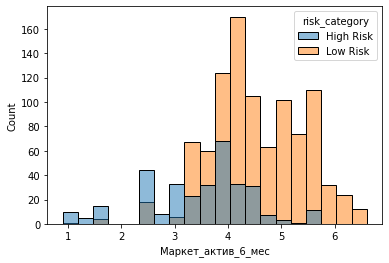

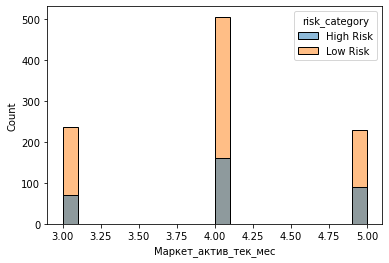

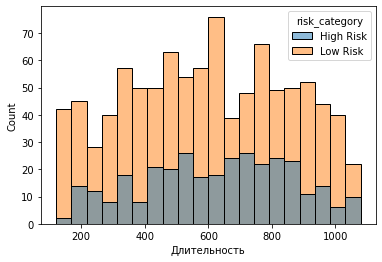

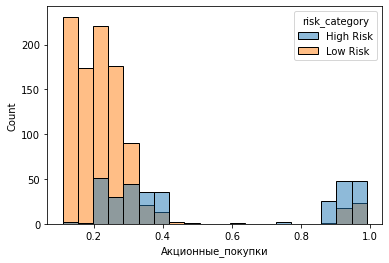

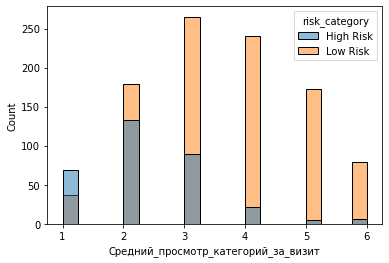

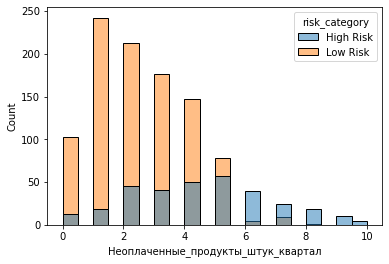

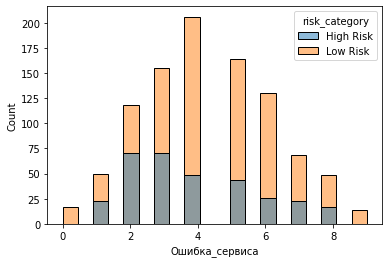

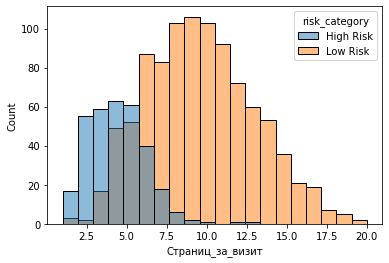

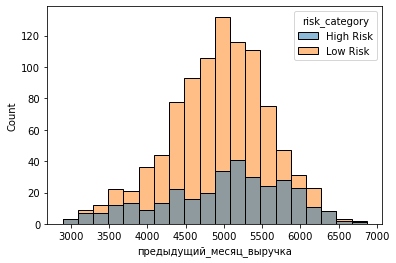

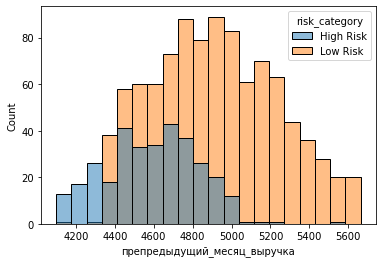

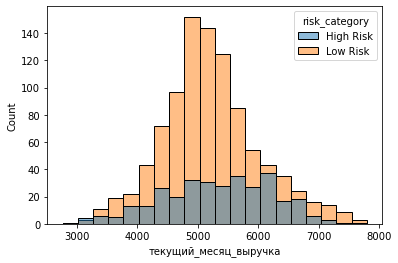

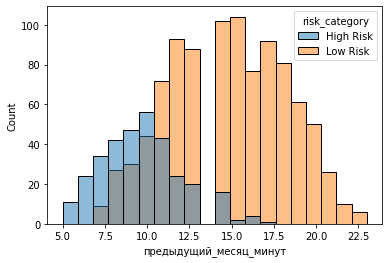

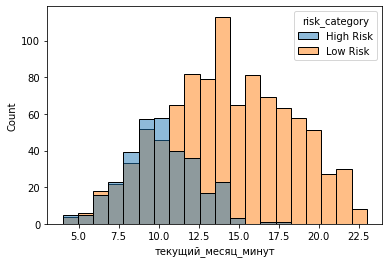

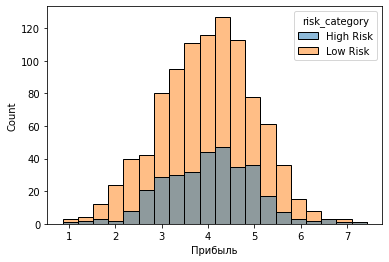

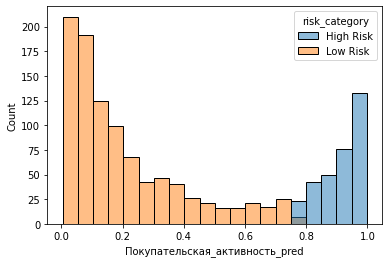

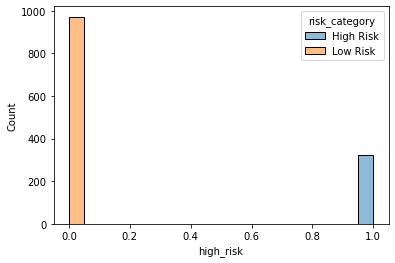

In [64]:
for column in num_columns:
    sns.histplot(data=data, x=column, hue='risk_category', bins=20)
    plt.show()

Заметим, что пользователи из сегмента с высоким риском приносят в среднем большую прибыль и большую выручку за текущий и предыдущий месяц, однако в препредыдущий месяц выручка этого сегмента была ниже. Также клиенты с высоким риском склонны больше покупать акционных товаров.

Для митигации риска снижения активности предложим следующие шаги:
- проанализировать корреляцию выручки по сегментам с сезонными праздниками
- кастомизировать маркетинговые кампании, чтобы более эффективно сообщать об акциях
- проанализировать причины неоплаченных покупок в корзине
- предлагать продукты из смежных категорий.

## Шаг 9. Общий вывод

В данном проекте были проанализированы данные интернет-магазина «В один клик», основная задача состоит в анализе потребительских предпочтений клиентов и персонализация предложения для митигации рисков снижения покупательской активности в дальнейшем. В рамках проекта были выполнены следующие шаги:
- загрузка данных: были загружены и изучены 4 датасета с исходными данными
- предобработка данных: были выявлены явные и неявные дубликаты, изучены пропуски
- исследовательский анализ данных: проведен анализ категориальных и количественных признаков, выявлены и обработаны аномалии
- объединение данных: датасеты преобразованы из "длинной" в "широкую" форму и объединены в один
- корреляционный анализ: проведен корреляционный анализ количественных признаков, где выявлено, что нет мультиколлинеарности между признаками
- модель: преобразованы количественные и качественные признаки, обучены ряд моделей, выбрана наилучшая модель на основе метрики roc auc; лучшая модель - модель логистической регрессии с параметрами: C=1, penalty='l1', solver='liblinear' (целевая метрика roc_auc = 0.9)
- анализ важности признаков: проведен анализ важности признаков с помощью метода SHAP, выделены наиболее значимые признаки для динамики покупательской активности
- сегментация пользователей: проведена сегментация клиентов, выделен сегмент, наиболее подверженный риску снижения покупательской активности и предлодены меры для митигации данного риска

В рамках данного проекта был выделен наиболее рисковой сегмент на основе ML-модели и предложены меры по снижению данного риска, которые компания может применить.